# Introduction
## Author
[George Datseris](https://github.com/Datseris),
contributor of [JuliaDynamics](https://github.com/JuliaDynamics)
and [JuliaMusic](https://github.com/JuliaDynamics)

## This tutorial
In this tutorial we will simulate a dynamical billiard. This is a very simple
system where a point particle is propagating inside a domain with constant speed.
When encountering a boundary, the particle undergoes specular reflection.

There is a Julia package to simulate these kind of systems,
[`DynamicalBilliards`](github.com/JuliaDynamics/DynamicalBilliards.jl).
In this tutorial we are simply creating a simplified version of this package
that has less features, less performance and less "safety control".
Other than that, the core of how `DynamicalBilliards` works
is identical to the present tutorial.

## Features of Julia highlighted
* Intuitive coding of the problem
* High-end Performance without doing anything
* Simple metaprogramming for performance gain
* Extendability with least possible effort
* Extandability applies to _all_ aspects of the system (Multiple Dispatch)

---

# The system and algorithm
A billiard is composed of three things:
1. Particles that propagate inside the billiard
2. Obstacles that compose the billiard
3. Processes that perform the propagation

It is important that these three things, "particles", "obstacles" and
"processes" remain **independent**. This will allow our code to be extendable!

## The Algorithm
To simulate a billiard one has to follow a very simple algorithm.
Assuming that a particle `p` has already been initialized in the billiard,
the steps are
1. Calculate the collisions of `p` with all obstacles in the billiard
2. Find the collision that happens first in time, and the obstacle it corresponds to
3. Propagate the particle to this collision point
4. Do specular reflection at the boundary of the obstacle to be collided with
5. Rinse and repeat!

The most central part of this algorithm is a function that
given a particle and obstacle it returns the collision (point and time, if they exists).
What is crucial is that this function does not "belong" anywhere. It is
a process, independent of what obstacle and particle we give it. This
independence allows the code to become highly extendable (see below).

This independence is possible only through multiple dispatch. Without it, one way
or the other, this method would be made to "belong" in either an
`Obstacle` "class" or a `Particle` "class". This would imped extendability though!
Not having to "assing" a process to a specific "class" is a huge benefit of Julia.

# The basic `struct`s we will need

All vectors we'll use are two dimensional.
We can therefore take advantage of `StaticArrays`. For a shortcut, I'll define
`SV` to be a 2D vector of Floats (all the vectors we will use will be of this type)

In [1]:
using StaticArrays
const SV = SVector{2,Float64}

SArray{Tuple{2},Float64,1,2}

We now define the particle `struct`.
For extendability, it is best to define it
based on an abstract type.

In [2]:
abstract type AbstractParticle end

mutable struct Particle <: AbstractParticle
    pos::SV
    vel::SV
end
Particle(x0, y0, φ0) = Particle(SV(x0, y0), SV(cos(φ0), sin(φ0)))

Particle

Then, we define the obstacle `struct`s. Again, to allow extendability, abstraction and
generalization, it is best to define all obstacles as a subtype of an abstract type.

In [3]:
abstract type Obstacle end

struct Wall <: Obstacle
    sp::SV
    ep::SV
    normal::SV
end

struct Disk <: Obstacle
    c::SV
    r::Float64
end

A "billiard" in the following will simply be a `Tuple` of `Obstacle` subtypes.
Specifically, the type of the billiard is ` NTuple{N, Obstacle} where {N}`, so it is
convenient to define:

In [4]:
const Billiard = NTuple{N, Obstacle} where N

Tuple{Vararg{Obstacle,N}} where N

# Propagation
## Collisions
As said in the introduction, the most important part is a function that
finds collisions between particles and obstacles. Here is how this looks for
collision of a standard particle with a wall:

In [5]:
using LinearAlgebra: dot, normalize

"""
    collision(p::AbstractParticle, o::Obstacle) → t, cp
Find the collision (if any) between given particle and obstacle.
Return the time until collision and the estimated collision point `cp`.
"""
@inline function collision(p::Particle, w::Wall)
    n = normalvec(w, p.pos)
    denom = dot(p.vel, n)
    if denom ≥ 0.0
        return nocollision()
    else
        t = dot(w.sp - p.pos, n)/denom
        return t, p.pos + t * p.vel
    end
end

normalvec(w::Wall, pos) = w.normal

normalvec (generic function with 1 method)

and here is the same function but for collisions with disks instead:

In [6]:
@inline function collision(p::Particle, d::Disk)
    dotp = dot(p.vel, normalvec(d, p.pos))
    dotp ≥ 0.0 && return nocollision()

    dc = p.pos - d.c
    B = dot(p.vel, dc)           #pointing towards circle center: B < 0
    C = dot(dc, dc) - d.r*d.r    #being outside of circle: C > 0
    Δ = B*B - C

    Δ ≤ 0.0 && return nocollision()
    sqrtD = sqrt(Δ)
    # Closest point:
    t = -B - sqrtD
    return t, p.pos + t * p.vel
end

normalvec(d::Disk, pos) = normalize(pos - d.c)

normalvec (generic function with 2 methods)

You can see that there are cases where collisions are not possible _or_ they happen
backwards in time. By convention, this is the value we return then:

In [7]:
@inline nocollision() = (Inf, SV(0.0, 0.0))

nocollision (generic function with 1 method)

`next_collision` is a useful function that finds the "true" next collision.
It simply loops over the obstacles in a billiard. It simply checks
which obstacle has the least collision time:

In [8]:
function next_collision(p::AbstractParticle, bd)
    j, ct, cp = 0, Inf, SV(0.0, 0.0)
    for i in eachindex(bd)
        t, c = collision(p, bd[i])
        if t < ct
            j = i
            ct = t
            cp = c
        end
    end
    return j, ct, cp
end

next_collision (generic function with 1 method)

# Evolving a particle in a billiard

We need a simple function to propagate a particle to the found collision point.
We will also a give the amount of time the propagation "should" take,
for extendability. For standard particles, where the velocity vector is constant
while travelling, this does not matter.

In [9]:
propagate!(p::Particle, pos, t) = (p.pos = pos)

propagate! (generic function with 1 method)

This is an *in-place* function (notice `!` at the end)

We also have to define a function that performs specular reflection
i.e. changes the velocity of the particle (after collision)

In [10]:
function resolvecollision!(p::AbstractParticle, o::Obstacle)
    n = normalvec(o, p.pos)
    p.vel = p.vel - 2*dot(n, p.vel)*n
end

resolvecollision! (generic function with 1 method)

We are now ready to wrap things up. Let's define a function
that takes a particle and evolves in a billiard (tuple of obstacles)
and returns the timeseries of the positions of the particle.

For convenience, it is worthwhile to define the following function:

In [11]:
"""
    bounce!(p, bd)
Evolve the particle for one collision (in-place).
"""
@inline function bounce!(p::AbstractParticle, bd)
    i::Int, tmin::Float64, cp::SV = next_collision(p, bd)
    if tmin != Inf
        propagate!(p, cp, tmin)
        resolvecollision!(p, bd[i])
    end
    return i, tmin, p.pos, p.vel
end

bounce!

Then, we can use it inside a bigger function that calls `bounce!` until
a specified amount of time:

In [12]:
"""
    timeseries!(p::AbstractParticle, bd, n) -> xt, yt, t
Evolve the particle in the billiard `bd` for `n` collisions
and return the position timeseries `xt, yt` along with time vector `t`.
"""
function timeseries!(p::AbstractParticle, bd, n::Int)

    t = [0.0]; xt = [p.pos[1]]; yt = [p.pos[2]]; c = 0

    while c < n
        prevpos = p.pos; prevvel = p.vel
        i, ct = bounce!(p, bd)
        xs, ys = extrapolate(p, prevpos, prevvel, ct)
        push!(t, ct)
        append!(xt, xs)
        append!(yt, ys)
        c += 1
    end

    return xt, yt, t
end

timeseries!

`extrapolate` simply creates the position timeseries in between two collisions.
For a standard particle there is no "extrapolation" needed, one just uses
the final position:

In [13]:
extrapolate(p::Particle, prevpos, prevvel, ct) = p.pos

extrapolate (generic function with 1 method)

Why does this `extrapolate` function exist? See below when we extend our code
for magnetic particles!

# Running the code

let's put this to the test now! We'll create the famous Sinai billiard

In [14]:
x, y, r = 1.0, 1.0, 0.3
sp = [0.0,y]; ep = [0.0, 0.0]; n = [x,0.0]
leftw = Wall(sp, ep, n)
sp = [x,0.0]; ep = [x, y]; n = [-x,0.0]
rightw = Wall(sp, ep, n)
sp = [x,y]; ep = [0.0, y]; n = [0.0,-y]
topw = Wall(sp, ep, n)
sp = [0.0,0.0]; ep = [x, 0.0]; n = [0.0,y]
botw = Wall(sp, ep, n)
disk = Disk([x/2, y/2], r)

bd = (botw, rightw, topw, leftw, disk)
bd isa Billiard

true

and also initialize a particle

In [15]:
p = Particle(0.1, 0.1, 2π*rand())

Particle([0.1, 0.1], [0.66869, -0.743542])

and evolve it

In [16]:
xt, yt, t = timeseries!(p, bd, 10)

([0.1, 0.189933, 0.388961, 0.383237, 0.377387, 0.110386, 0.0, 0.262878, 0.0, 0.184043, 0.468976], [0.1, 0.0, 0.221306, 0.0, 0.226201, 0.0, 0.093518, 0.316225, 0.130222, 0.0, 0.201608], [0.0, 0.134491, 0.297638, 0.22138, 0.226276, 0.349938, 0.144674, 0.344534, 0.322028, 0.225454, 0.349045])

# Plotting
Let's define some simple methods for plotting and plot the result!

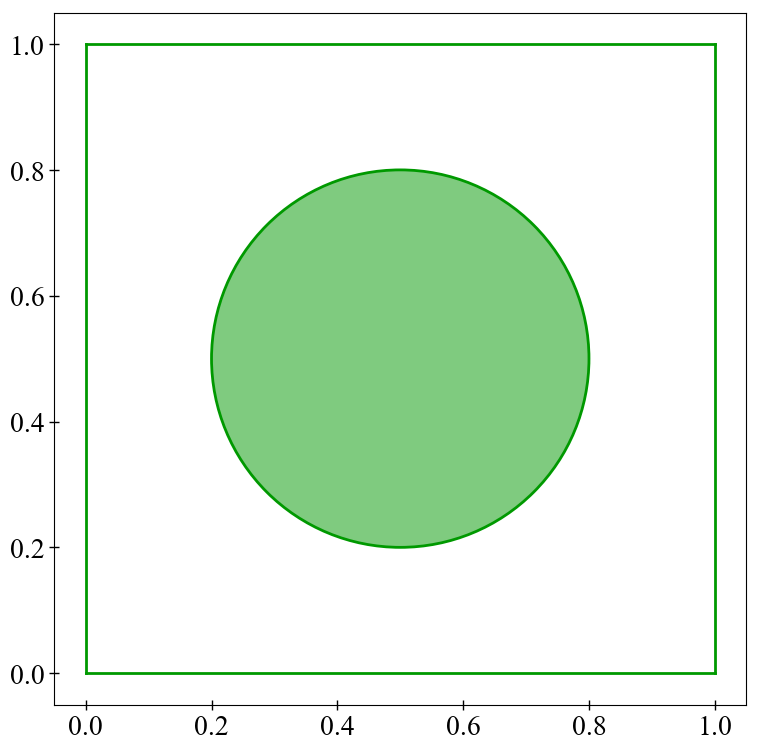

In [17]:
using PyPlot
import PyPlot: plot

const EDGECOLOR = (0,0.6,0)
function plot(d::Disk)
    facecolor = (EDGECOLOR..., 0.5)
    circle1 = PyPlot.plt[:Circle](d.c, d.r;
        edgecolor = EDGECOLOR, facecolor = facecolor, lw = 2.0)
    PyPlot.gca()[:add_artist](circle1)
end
function plot(w::Wall)
    PyPlot.plot([w.sp[1],w.ep[1]],[w.sp[2],w.ep[2]];
        color=EDGECOLOR, lw = 2.0)
end
function plot(bd::Billiard)
    for o ∈ bd; plot(o); end
    gca()[:set_aspect]("equal")
end

figure(); plot(bd)

Awesome! Now let's see it with the orbit as well

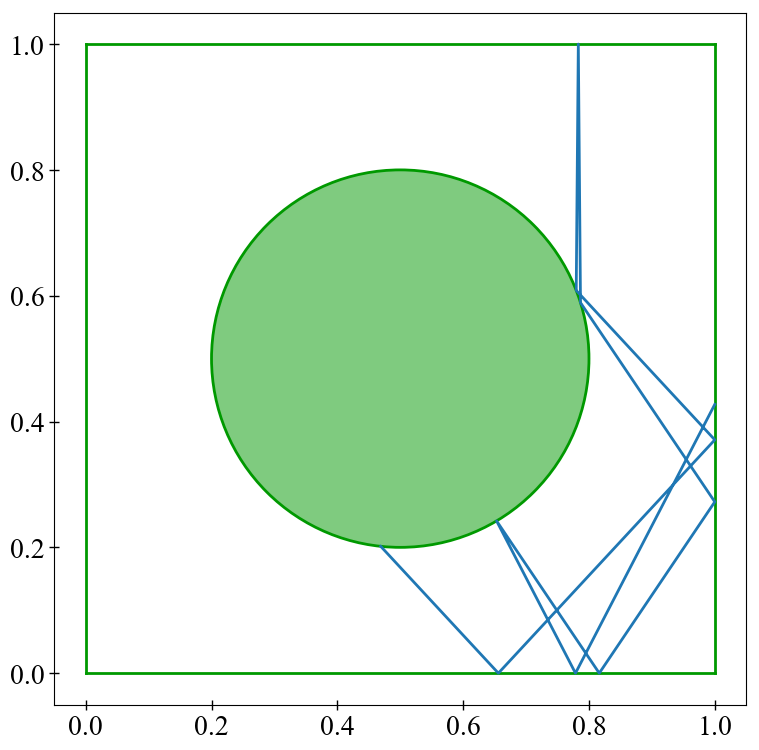

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x00000000246972B0>

In [18]:
figure(); plot(bd)
xt, yt, t = timeseries!(p, bd, 10)
plot(xt, yt)

Plot 10 orbits!

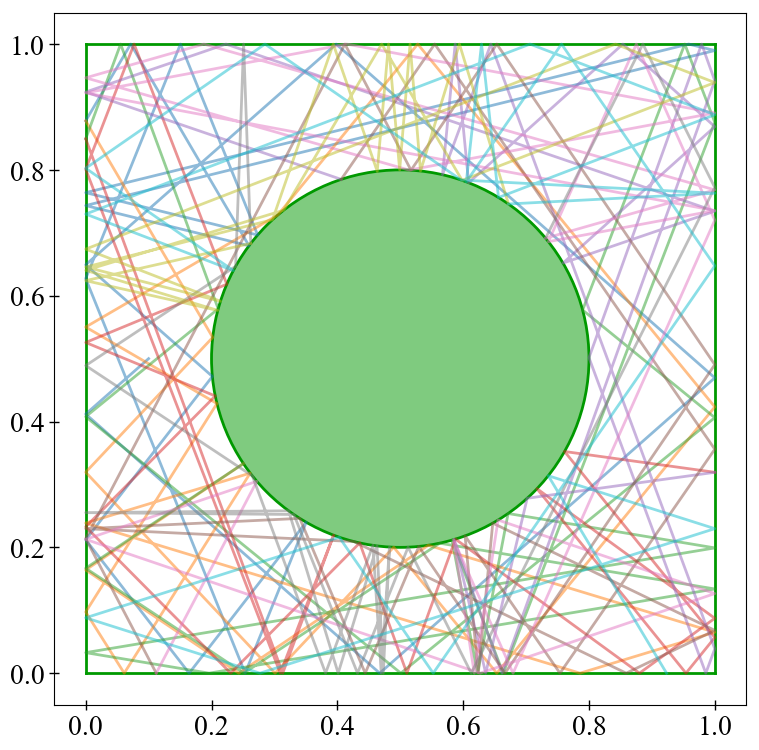

In [19]:
figure(); plot(bd)
p = Particle(0.1, 0.5, 2π*rand())
for j in 1:10
    xt, yt = timeseries!(p, bd, 20)
    plot(xt, yt, alpha = 0.5)
end

# Showcase 1: Performance & Metaprogramming

In [20]:
using BenchmarkTools

p = Particle(0.1, 0.1, 2π*rand())
@btime bounce!($p, $bd)

  347.806 ns (12 allocations: 1.64 KiB)


(1, 0.6278167113229192, [0.383222, 0.0], [0.610404, 0.79209])

It is already very fast to propagate a particle for one collision,
however there are some allocations (even though the function is in place).

These allocations come from type instability in `next_collision`,
since the `Tuple` contains elements of
different types. However, using metaprogramming it is easy to solve
this type instability because `Tuple` has known size!

What we do in the following definition is using metaprogramming to "unroll" the loop

In [21]:
@generated function next_collision(p::AbstractParticle, bd::Billiard)
    L = length(bd.types) # notice that bd stands for the TYPE of bd here!
    out = :(ind = 0; tmin = Inf; cp = SV(0.0, 0.0))
    for j=1:L
        push!(out.args, quote
                            let x = bd[$j]
                                tcol, pcol = collision(p, x)
                                # Set minimum time:
                                if tcol < tmin
                                  tmin = tcol
                                  ind = $j
                                  cp = pcol
                                end
                            end
                        end
                        )
    end
    push!(out.args, :(return ind, tmin, cp))
    return out
end


@btime bounce!($p, $bd)

  90.204 ns (2 allocations: 276 bytes)


(5, 0.45096803440799055, [0.599414, 0.216951], [-0.405981, -0.913882])

This number is **insane**!!! Notice that this code is billiard agnostic!
You could pass any tuple of obstacles and it would still be as performant!!!
The time of `bounce!` scales linearly with the number of obstacles in the billiard.

# Showcase 2: Extendability
Let's say we want to add one more obstacle to this "billiard package" we
are making. Do you we have to re-write *everything* for it? Nope!
In the end we only need to extend two methods ! **Only two**!

To show this let's create an ellipse as an obstacle, with semi-axes `a, b`

In [22]:
struct Ellipse <: Obstacle
    c::SV
    a::Float64
    b::Float64
end

The methods we need to extend are only these:
```julia
normalvec
collision
```
Yes!!! Only two! So let's get to it! `normalvec` is pretty easy:

In [23]:
function normalvec(e::Ellipse, pos)
    x₀, y₀ = pos
    h, k = e.c
    return normalize(SV((x₀-h)/(e.a*e.a), (y₀-k)/(e.b*e.b)))
end

using LinearAlgebra: norm
function collision(p::Particle, e::Ellipse)
    dotp = dot(p.vel, normalvec(e, p.pos))
    dotp ≥ 0.0 && return nocollision()

    a = e.a; b = e.b
    pc = p.pos - e.c
    μ = p.vel[2]/p.vel[1]
    ψ = pc[2] - μ*pc[1]

    denomin = a*a*μ*μ + b*b
    Δ² = denomin - ψ*ψ
    Δ² ≤ 0 && return nocollision()
    Δ = sqrt(Δ²); f1 = -a*a*μ*ψ; f2 = b*b*ψ # just factors
    I1 = SV(f1 + a*b*Δ, f2 + a*b*μ*Δ)/denomin
    I2 = SV(f1 - a*b*Δ, f2 - a*b*μ*Δ)/denomin

    d1 = norm(pc - I1); d2 = norm(pc - I2)
    return d1 < d2 ? (d1, I1 + e.c) : (d2, I2 + e.c)
end

collision (generic function with 3 methods)

Alright so now let's create a billiard with both an ellipse and a disk, for the
fun of it

In [24]:
el = Ellipse([0.4, 0.2 ], 0.3, 0.1)
di = Disk([0.6, 0.7], 0.25)

bd2 = Billiard((bd[1:4]..., el, di))

(Wall([0.0, 0.0], [1.0, 0.0], [0.0, 1.0]), Wall([1.0, 0.0], [1.0, 1.0], [-1.0, 0.0]), Wall([1.0, 1.0], [0.0, 1.0], [0.0, -1.0]), Wall([0.0, 1.0], [0.0, 0.0], [1.0, 0.0]), Ellipse([0.4, 0.2], 0.3, 0.1), Disk([0.6, 0.7], 0.25))

and plot it

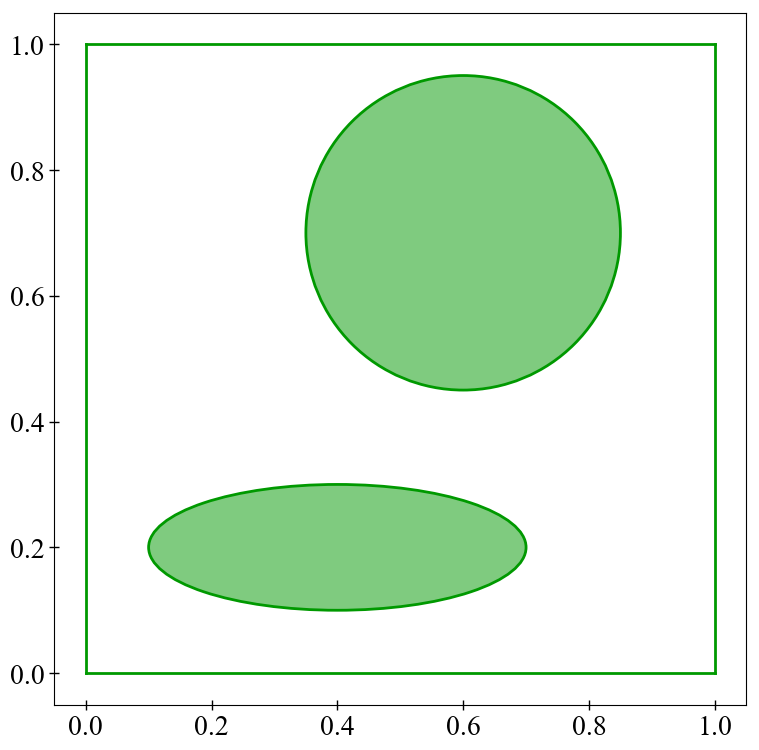

In [25]:
function plot(e::Ellipse)
    facecolor = (EDGECOLOR..., 0.5)
    ellipse = PyPlot.matplotlib[:patches][:Ellipse](e.c, 2e.a, 2e.b;
        edgecolor = EDGECOLOR, facecolor = facecolor, lw = 2.0)
    PyPlot.gca()[:add_artist](ellipse)
end

figure(); plot(bd2)

We are now ready to evolve a particle in this brand new billiard:

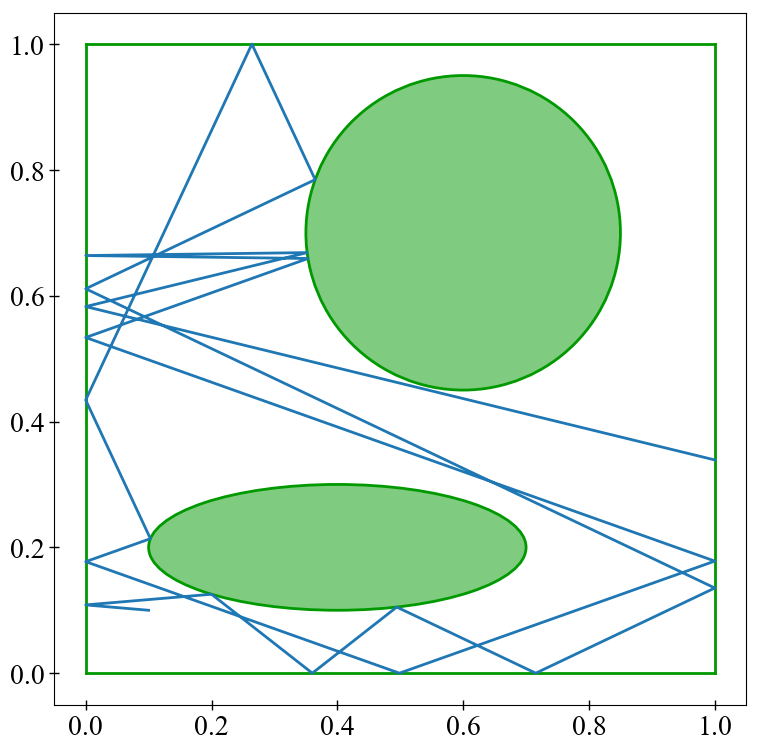

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000031BE1828>

In [26]:
p = Particle(0.1, 0.1, 2π*rand())
xt, yt, t = timeseries!(p, bd2, 20)
figure(); plot(bd2)
plot(xt, yt)

plot a bunch more!

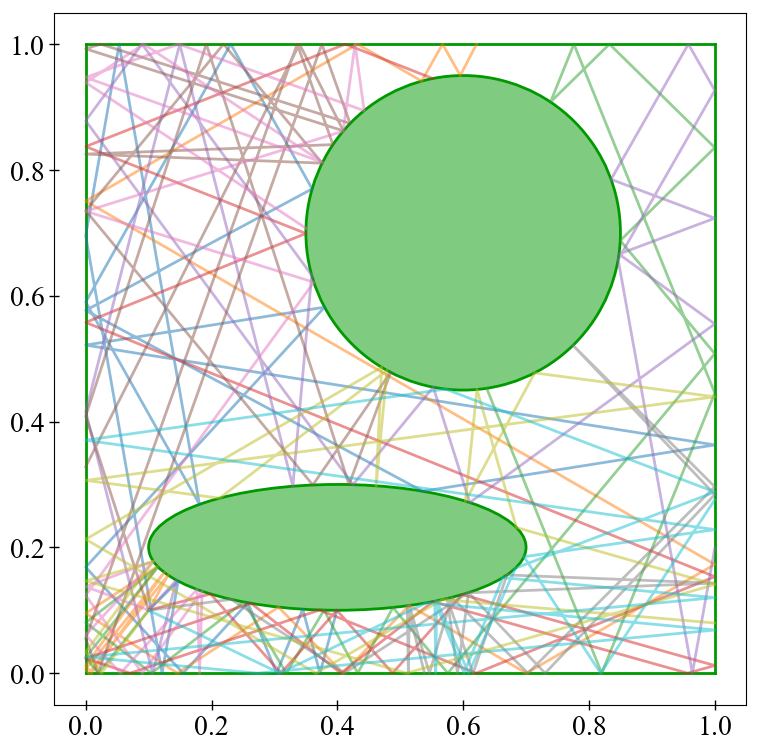

In [27]:
figure(); plot(bd2)
for j in 1:10
    p = Particle(0.1, 0.1, 2π*rand())
    xt, yt = timeseries!(p, bd2, 20)
    plot(xt, yt, alpha = 0.5)
end

# Showcase 2: Extendability, again.
Alright, so it turned out to be almost trivial to add an extra obstacle to
our code. But what about an extra particle?

I am not talking about one more instance of `Particle`. I am talking about a new *type*
of particle, that moves around in a different way.

In this part we will create this new type, `MagneticParticle` that moves around in
circles instead of straight lines! But how many functions do we need to define?
Provided you have already defined the type `MagneticParticle`, then that many:
```julia
collision # for each obstacle we want to support
propagate!
extrapolate
```
and yeap, that's it. It may be hard to believe that it only takes so little,
but it's true!!!

## The type

In [28]:
mutable struct MagneticParticle <: AbstractParticle
    pos::SV
    vel::SV
    ω::Float64
end
MagneticParticle(x0, y0, φ0, ω) = MagneticParticle(SV(x0, y0), SV(cos(φ0), sin(φ0)), ω)

MagneticParticle

This particle moves in circles with angular velocity `ω`.

## Extending `collision`
To extend `collision`, we simply have to find intersections of circle-line
and circle-circle, for collisions with `Wall` and `Disk`. I won't go into
details of how to do this, and instead I'll copy-paste functions from
`DynamicalBilliards`. The versions in `DynamicalBilliards` also have a
lot of comments that explain what is going on.

Here is the collision with wall:

In [29]:
function collision(p::MagneticParticle, w::Wall)
    ω = p.ω
    pc, pr = cyclotron(p)
    P0 = p.pos
    P2P1 = w.ep - w.sp
    P1P3 = w.sp - pc

    a = dot(P2P1, P2P1)
    b = 2*dot(P2P1, P1P3)
    c = dot(P1P3, P1P3) - pr*pr
    Δ = b^2 -4*a*c

    Δ ≤ 0.0 && return nocollision()
    u1 = (-b - sqrt(Δ))/2a
    u2 = (-b + sqrt(Δ))/2a
    cond1 = 0.0 ≤ u1 ≤ 1.0
    cond2 = 0.0 ≤ u2 ≤ 1.0
    θ, I = nocollision()
    if cond1 || cond2
        dw = w.ep - w.sp
        for (u, cond) in ((u1, cond1), (u2, cond2))
            Y =  w.sp + u*dw
            if cond
                φ = realangle(p, w, Y)
                φ < θ && (θ = φ; I = Y)
            end
        end
    end
    return θ*pr, I
end

collision (generic function with 4 methods)

and here is the collision with a disk:

In [30]:
function collision(p::MagneticParticle, o::Disk)
    ω = p.ω
    pc, rc = cyclotron(p)
    p1 = o.c
    r1 = o.r
    d = norm(p1-pc)
    if (d >= rc + r1) || (d <= abs(rc-r1))
        return nocollision()
    end

    a = (rc^2 - r1^2 + d^2)/2d
    h = sqrt(rc^2 - a^2)

    I1 = SV(
        pc[1] + a*(p1[1] - pc[1])/d + h*(p1[2] - pc[2])/d,
        pc[2] + a*(p1[2] - pc[2])/d - h*(p1[1] - pc[1])/d
    )
    I2 = SV(
        pc[1] + a*(p1[1] - pc[1])/d - h*(p1[2] - pc[2])/d,
        pc[2] + a*(p1[2] - pc[2])/d + h*(p1[1] - pc[1])/d
    )

    θ1 = realangle(p, o, I1)
    θ2 = realangle(p, o, I2)

    return θ1 < θ2 ? (θ1*rc, I1) : (θ2*rc, I2)
end

collision (generic function with 5 methods)

The functions `cyclotron` and `realangle` are helper functions.
The first one finds the center and radius of the cyclotron traced by the particle.

In [31]:
cyclotron(p) = (p.pos - (1/p.ω)*SV(p.vel[2], -p.vel[1]), abs(1/p.ω))

cyclotron (generic function with 1 method)

`realangle` has a simple purpose: the intersections of a circle
with any obstacle are always 2.
But which one happens first, from a temporal perspective? `realangle` gives the
correct angle until the collision point, in forward time.

In [32]:
function realangle(p::MagneticParticle, o::Obstacle, i)

    pc, pr = cyclotron(p); ω = p.ω
    P0 = p.pos
    PC = pc - P0
    d2 = dot(i-P0,i-P0)

    if d2 ≤ 1e-8
        dotp = dot(p.vel, normalvec(o,  p.pos))
        dotp ≥ 0 && return Inf
    end

    d2r = (d2/(2pr^2))
    d2r > 2 && (d2r = 2.0)
    θprime = acos(1.0 - d2r)

    PI = i - P0
    side = (PI[1]*PC[2] - PI[2]*PC[1])*ω

    side < 0 && (θprime = 2π-θprime)
    return θprime
end

realangle (generic function with 1 method)

The complexity of the functions `collision` and `realangle` exists
solely due to the geometry of intersections between circles. What we want to point out
is how **few** methods we have to extend. How easy is defining these new methods
is not relevant, blame math and physics for that!
So don't be taken aback because these functions are "long"!

## Propagation & extrapolation
`propagate!` for a `MagneticParticle` must evolve it in an arc of a circle,
so as you can see we have to change the velocity vector!

In [33]:
function propagate!(p::MagneticParticle, pos, t)
    φ0 = atan(p.vel[2], p.vel[1])
    p.pos = pos
    p.vel = SV(cossin(p.ω*t + φ0))
    return
end

cossin(x) = ( (y, z) = sincos(x); (z, y) )

cossin (generic function with 1 method)

`extrapolate` should simply create the arc that connects the previous point
with the current one

In [34]:
function extrapolate(p::MagneticParticle, prevpos, prevvel, t)
    φ0 = atan(prevvel[2], prevvel[1])
    s0, c0 = sincos(φ0)
    x0 = prevpos[1]; y0 = prevpos[2]
    xt = [x0]; yt = [y0]; ω = p.ω
    tvec = 0.0:0.01:t
    for td in tvec
        s, c = sincos(p.ω*td + φ0)
        push!(xt, s/ω + x0 - s0/ω)
        push!(yt, -c/ω + y0 + c0/ω) #vx0 is cos(φ0)
    end
    return xt, yt
end

extrapolate (generic function with 2 methods)

# Evolve the magnetic particle

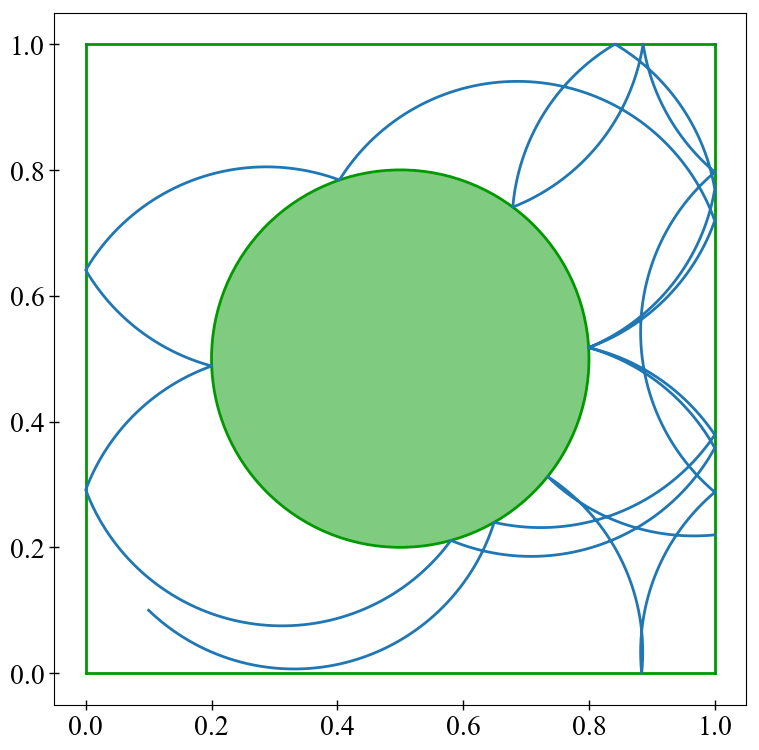

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000032470A58>

In [35]:
p = MagneticParticle(0.1, 0.1, 2π*rand(), 3.0)
xt, yt, t = timeseries!(p, bd, 20)
figure(); plot(bd)
plot(xt, yt)

plot a bunch of these!

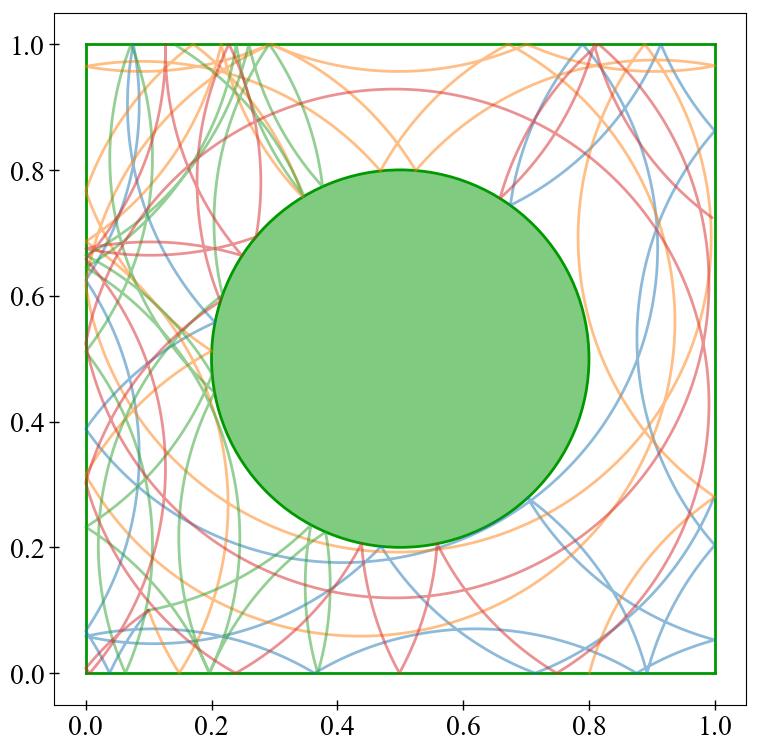

In [36]:
figure(); plot(bd)
for j in 1:4
    p = MagneticParticle(0.1, 0.1, 2π*rand(), 2.0)
    xt, yt = timeseries!(p, bd, 20)
    plot(xt, yt, alpha = 0.5)
end

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*